# Amazon Reviews for SA fine-grained 5 classes CSV


In [1]:
import re
import contractions
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from tqdm import tqdm
from textblob import TextBlob
from wordcloud import WordCloud
from time import perf_counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')

pd.options.mode.chained_assignment = None

plt.rcParams.update(plt.rcParamsDefault)


[nltk_data] Downloading package stopwords to C:\Users\Margarida
[nltk_data]     Viera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Margarida
[nltk_data]     Viera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Margarida
[nltk_data]     Viera\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
[nltk_data] Downloading package wordnet to C:\Users\Margarida
[nltk_data]     Viera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Margarida
[nltk_data]     Viera\AppData\Roaming\nltk_data...


## Dataset


In [2]:
train_df = pd.read_csv('../docs/train.csv').dropna()
test_df = pd.read_csv('../docs/test.csv').dropna()


In [3]:
# Shorten the number of samples from every class_index type (n = 5000)

classes = []
n_samples = 5000

for i in range(1, 6):
    classes.append(train_df.query(f'class_index == {i}').sample(n=n_samples))

train_df_s = pd.concat(classes)
train_df_s.reset_index(drop=True, inplace=True)


train_df_s['review_full'] = train_df_s['review_title'] + \
    ' ' + train_df_s['review_text']


## Exploratory analysis


In [4]:
# checking for presence of null values that might interfere with data processing
train_df.isna().sum()


class_index     0
review_title    0
review_text     0
dtype: int64

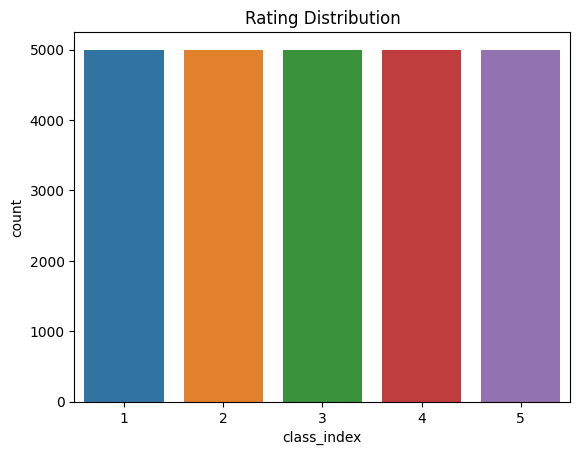

In [5]:
sb.countplot(x='class_index', data=train_df_s)
plt.title('Rating Distribution')
plt.show()


### Word distribution


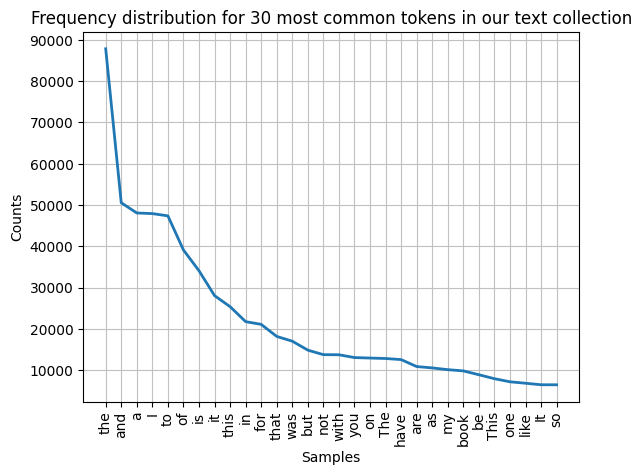

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection'}, xlabel='Samples', ylabel='Counts'>

In [6]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([w for w in c.split()])
fdist_filtered.plot(
    30, title='Frequency distribution for 30 most common tokens in our text collection')


In [7]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([w for w in train_df_s['review_full']])
tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names())
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
idf = pd.DataFrame({'feature_name': cv.get_feature_names(
), 'idf_weights': tfidf_transformer.idf_}).sort_values('idf_weights')
idf


c:\Users\Margarida Viera\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Margarida Viera\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature_name,idf_weights
50444,the,1.104201
3288,and,1.216109
51182,to,1.281501
50718,this,1.303310
27015,it,1.312835
...,...,...
35158,obdii,10.433524
35157,obbsessed,10.433524
15785,douay,10.433524
15788,doubler,10.433524


### Sentiment analysis


In [8]:
def sentiment_analysis(string):
    sentences = TextBlob(string).sentences
    sentiments = [s.sentiment.polarity for s in sentences]
    return sum(sentiments)/len(sentiments)


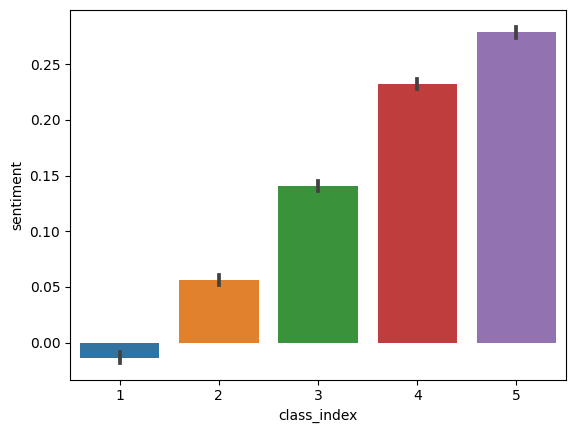

In [9]:
train_df_s['sentiment'] = train_df_s['review_title']
train_df_s['weight'] = train_df_s['review_title']

for i, review_full in enumerate(train_df_s['review_full']):
    sentiment = sentiment_analysis(review_full)
    train_df_s['sentiment'][i] = sentiment
    train_df_s['weight'][i] = 1 - \
        abs(((sentiment + 1) / 2) - (train_df_s['class_index'][i] / 5))

sb.barplot(data=train_df_s, x='class_index', y='sentiment')
plt.show()


## Preprocess data


In [10]:
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.extend(['book', 'movie', 'product', 'one', 'time', 'cd', 'dvd'])

words = list(nltk.corpus.words.words())
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def handle_negation(string_array):
    string = ''
    i = 0
    while(i < (len(string_array) - 1)):
        if (string_array[i] == 'not'):
            string = string + ' ' + 'NOT_' + string_array[i + 1]
            i += 1
        else:
            string = string + ' ' + string_array[i]
        i += 1
    return string


def preprocess_data(string):
    string = string.lower()
    text_contractions = [contractions.fix(w) for w in string.split()]
    string = re.sub("[^a-zA-Z]", " ", " ".join(text_contractions))
    string_list = word_tokenize(string)
    text_stems = [stemmer.stem(w) for w in string_list if w not in stop_words]
    return handle_negation(text_stems)


In [11]:
for i, review_full in tqdm(enumerate(train_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    train_df_s['review_full'][i] = preprocess_text

train_df_s.head()


25000it [00:43, 580.44it/s]


,class_index,review_title,review_text,review_full,sentiment,weight
0,1,"Sean McGrath sucks really, really bad...","Why do I even play with this guy? Sean ""Buttba...",sean mcgrath suck realli realli bad even play...,0.0175,0.69125
1,1,Junk !,This book is not worth to buy. It made easy ma...,junk NOT_worth buy made easi materi becom com...,-0.211667,0.805833
2,1,Support ended after just a year and a half????,I am an owner of Quicken Lawyer 2002 Personal ...,support end year half owner quicken lawyer pe...,0.040909,0.679545
3,1,"CONCUR with ""Poorly organized and executed""",This is probably one of the worst teaching CD'...,concur poorli organ execut probabl worst teac...,-0.007143,0.703571
4,1,UGH - 4 years and I STILL can't finish this book,I picked up this book because I heard she was ...,ugh year still NOT_finish pick heard great au...,0.150833,0.624583


### Word distribution after preprocessing


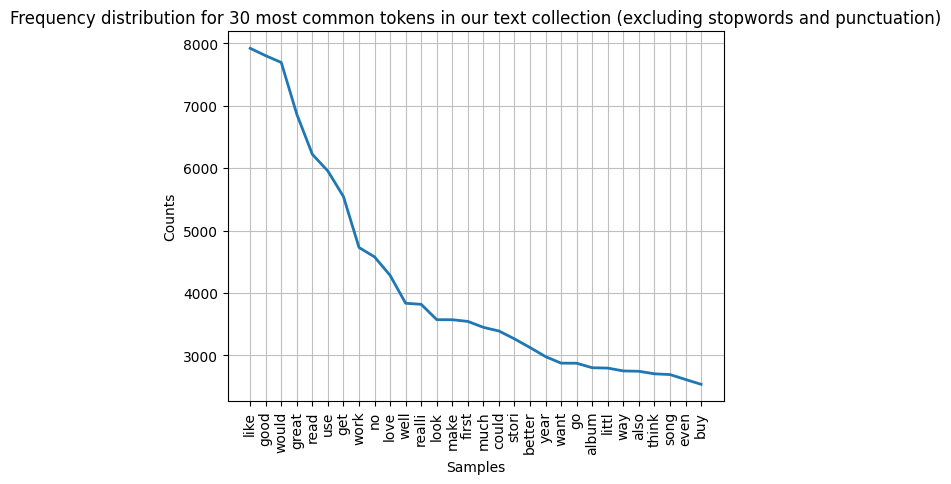

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [12]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([w for w in c.split()])
fdist_filtered.plot(
    30, title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')


In [13]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([w for w in train_df_s['review_full']])
tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names())
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
idf = pd.DataFrame({'feature_name': cv.get_feature_names(
), 'idf_weights': tfidf_transformer.idf_}).sort_values('idf_weights')
idf


c:\Users\Margarida Viera\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Margarida Viera\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature_name,idf_weights
19180,like,2.411119
40928,would,2.433845
13787,good,2.440073
14040,great,2.573918
13368,get,2.709740
...,...,...
18157,kirwain,10.433524
18154,kirov,10.433524
18151,kirino,10.433524
18194,kjsb,10.433524


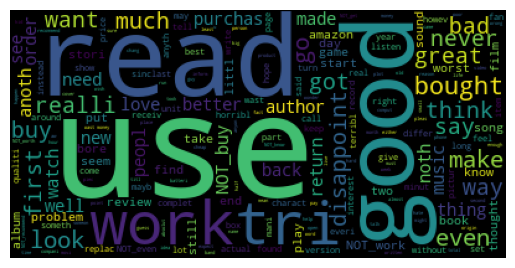

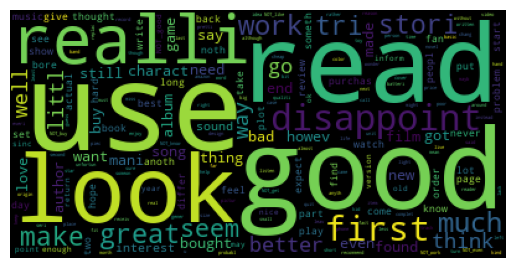

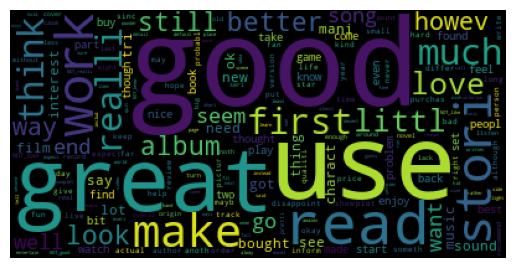

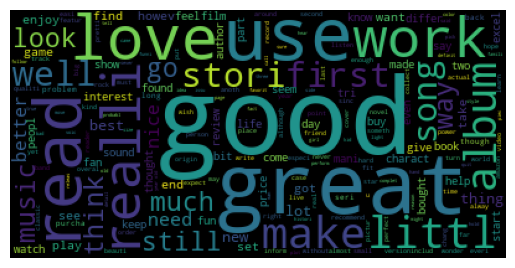

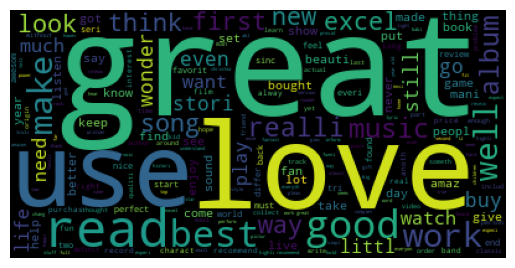

In [14]:
for i in range(1, 6):
    wordcloud = WordCloud().generate(" ".join(train_df_s['review_full'][j] for j in range(
        0, train_df_s['review_full'].shape[0]) if train_df_s['class_index'][j] == i))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


## Machine Learning


### Transform train dataset


In [15]:
corpus = train_df_s['review_full']

vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

X = Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).fit_transform(corpus)

y = train_df_s['class_index']


### Transform test dataset


In [16]:
n_samples = 5000

test_df_s = test_df.sample(n=n_samples)
test_df_s.reset_index(drop=True, inplace=True)

test_df_s['review_full'] = test_df_s['review_title'] + \
    ' ' + test_df_s['review_text']


for i, review_full in tqdm(enumerate(test_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    test_df_s['review_full'][i] = preprocess_text

corpus = test_df_s['review_full']

X_test = Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).transform(corpus)

y_test = test_df_s['class_index']


5000it [00:08, 576.32it/s]


In [17]:
test_df_s


,class_index,review_title,review_text,review_full
0,3,"Not completely my type of music, but still solid","I bought the album for the the songs ""Wedding ...",NOT_complet type music still solid bought alb...
1,4,Anybody who gave this a one star review...,...probably hasn't been lit up on ecstacy in a...,anybodi gave star review probabl NOT_lit ecst...
2,4,Great!,"I really liked this book. The end is....well, ...",great realli like end well ill let find read ...
3,5,A way to engage people in Bible studies,This book consists of 60 calligraphic renderin...,way engag peopl bibl studi consist calligraph...
4,3,"Works good, but...",I thought i would be able to use the remote fr...,work good thought would abl use remot anoth r...
...,...,...,...,...
4995,2,Canned corn in spades,If you think that going to the market and buyi...,can corn spade think go market buy can corn p...
4996,2,I hated it! How could anyone who loves her boo...,I have read the first 4 books of the Vampire C...,hate could anyon love book enjoy read first b...
4997,2,Unrelible,The quality of the ink was inferior to origina...,unrel qualiti ink inferior origin epson cartr...
4998,1,Why?!,Why does George Lucas insist on not listening ...,georg luca insist NOT_listen fan first jarjar...


### Model and training


In [18]:
accuracy = []
f1 = []
recall = []
precision = []
times_fit = []
times_predict = []

algorithms = ['Naive Bayes', 'Decision Tree', 'Neural Networks',
              'Suport Vector Machine', 'K-nearest Neighbors', 'Logistic Regression']


def algorithm_analysis(y_pred, y_test):
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred,  average='macro'))
    recall.append(recall_score(y_test, y_pred, average='macro'))
    precision.append(precision_score(y_test, y_pred, average='macro'))

    table_data = {
        'Accuracy': accuracy[-1],
        'Precision': precision[-1],
        'F1 score': f1[-1],
        'Recall score': recall[-1]}

    return pd.DataFrame([table_data]).style.hide_index()


#### Naive Bayes


In [19]:
et = perf_counter()
mnb_model = MultinomialNB().fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = mnb_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_mnb = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\2107546914.py:24: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return pd.DataFrame([table_data]).style.hide_index()


Accuracy,Precision,F1 score,Recall score
0.458600,0.458730,0.458297,0.458765


#### Decision Tree


In [20]:
et = perf_counter()
dtc_model = DecisionTreeClassifier().fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = dtc_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_dct = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\2107546914.py:24: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return pd.DataFrame([table_data]).style.hide_index()


Accuracy,Precision,F1 score,Recall score
0.348200,0.346941,0.347519,0.348427


#### Neural Networks


In [21]:
et = perf_counter()
nn_model = MLPClassifier(hidden_layer_sizes=(
    150, 100, 50), max_iter=500, activation='relu', solver='adam', random_state=1).fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = nn_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_nn = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\2107546914.py:24: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return pd.DataFrame([table_data]).style.hide_index()


Accuracy,Precision,F1 score,Recall score
0.407000,0.405996,0.406451,0.407091


#### Suport Vector Machine


In [22]:
et = perf_counter()
sgdc_model = SVC(decision_function_shape='ovo').fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = sgdc_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_sgdc = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\2107546914.py:24: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return pd.DataFrame([table_data]).style.hide_index()


Accuracy,Precision,F1 score,Recall score
0.486000,0.483058,0.484397,0.486102


#### K Nearest Neighbors


In [23]:
et = perf_counter()
knc_model = KNeighborsClassifier(n_neighbors=50).fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = knc_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_knc = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\2107546914.py:24: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return pd.DataFrame([table_data]).style.hide_index()


Accuracy,Precision,F1 score,Recall score
0.375800,0.366240,0.366862,0.376341


#### Logistic Regression


In [24]:
et = perf_counter()
lr_model = LogisticRegression().fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = lr_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_lr = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


c:\Users\Margarida Viera\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\2107546914.py:24: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return pd.DataFrame([table_data]).style.hide_index()


Accuracy,Precision,F1 score,Recall score
0.485800,0.479788,0.482034,0.486016


# Results


C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\3889263528.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5])
C:\Users\Margarida Viera\AppData\Local\Temp\ipykernel_27056\3889263528.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels([0, 1, 2, 3, 4, 5])


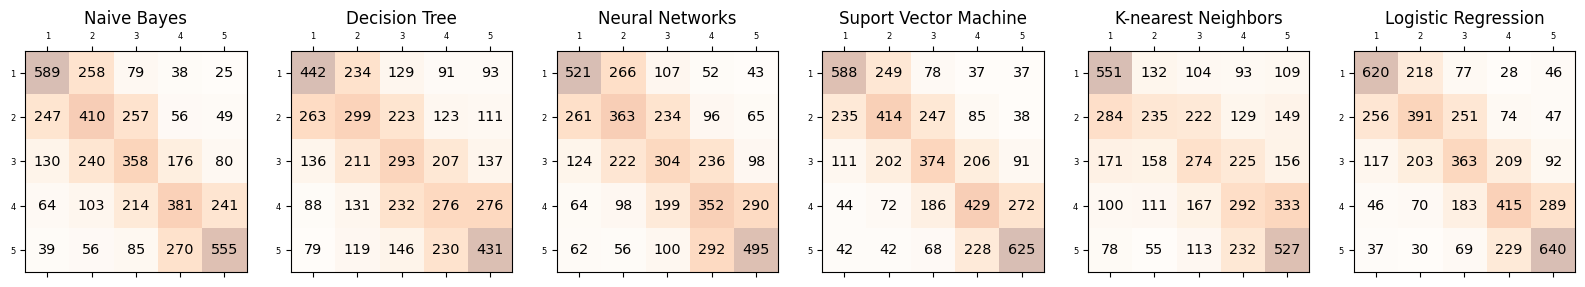

In [25]:
plt.rcParams['font.size'] = '6'

fig, axs = plt.subplots(1, 6, figsize=(20, 5))
matrixes = [confusion_matrix_mnb, confusion_matrix_dct, confusion_matrix_nn,
            confusion_matrix_sgdc, confusion_matrix_knc, confusion_matrix_lr]
for index, ax in enumerate(axs):
    ax.matshow(matrixes[index], cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(matrixes[index].shape[0]):
        for j in range(matrixes[index].shape[1]):
            ax.text(x=j, y=i, s=matrixes[index][i, j],
                    va='center', ha='center', size='xx-large')
    ax.set_title(algorithms[index], fontsize='12')
    ax.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5])
    ax.yaxis.set_ticklabels([0, 1, 2, 3, 4, 5])


plt.show()


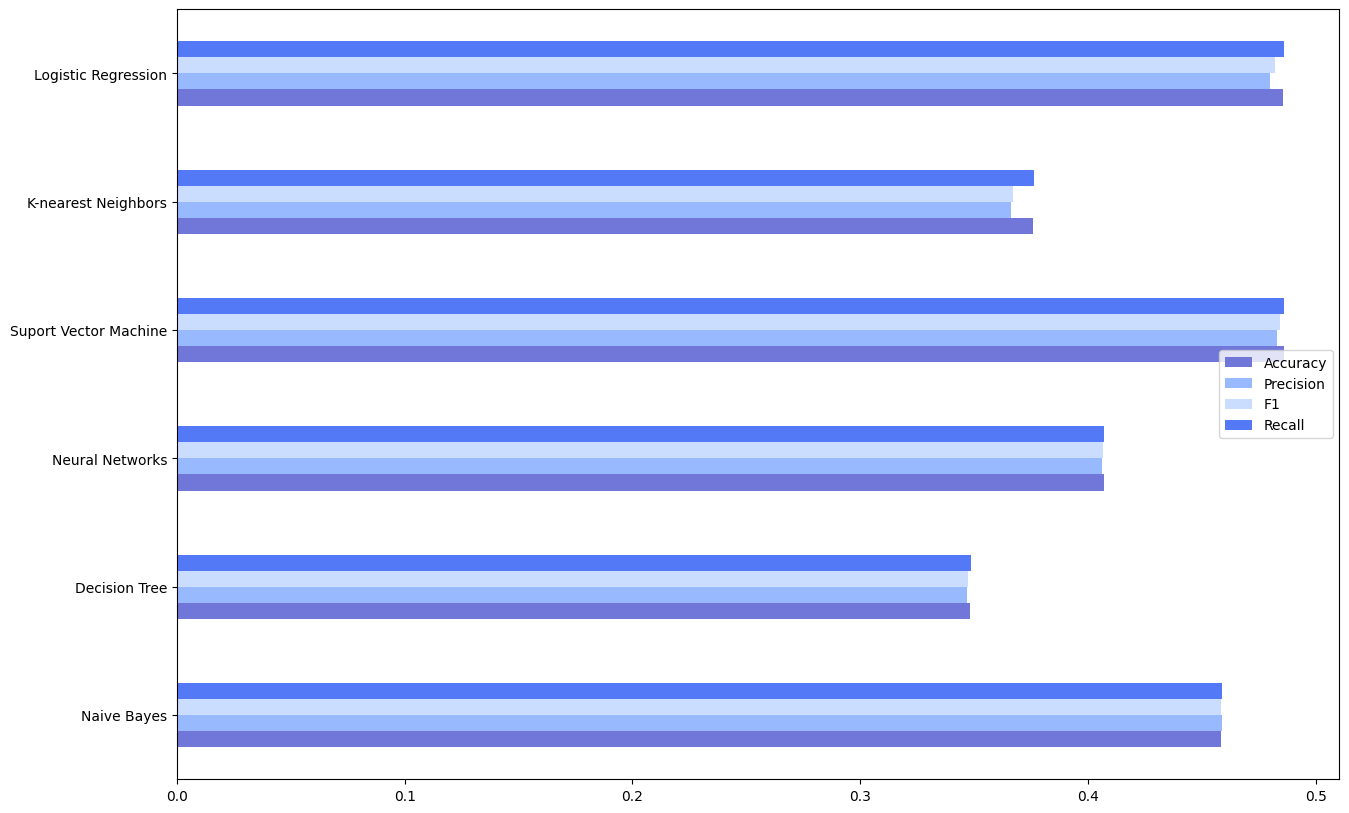

In [26]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams['font.size'] = '10'

data = {
    'Accuracy': accuracy,
    'Precision': precision,
    'F1': f1,
    'Recall': recall,
}
df = pd.DataFrame(data, algorithms)
ax = df.plot.barh(color=['#7077D8', '#99B9FF', '#CADDFF', '#5479F7'])
plt.show()


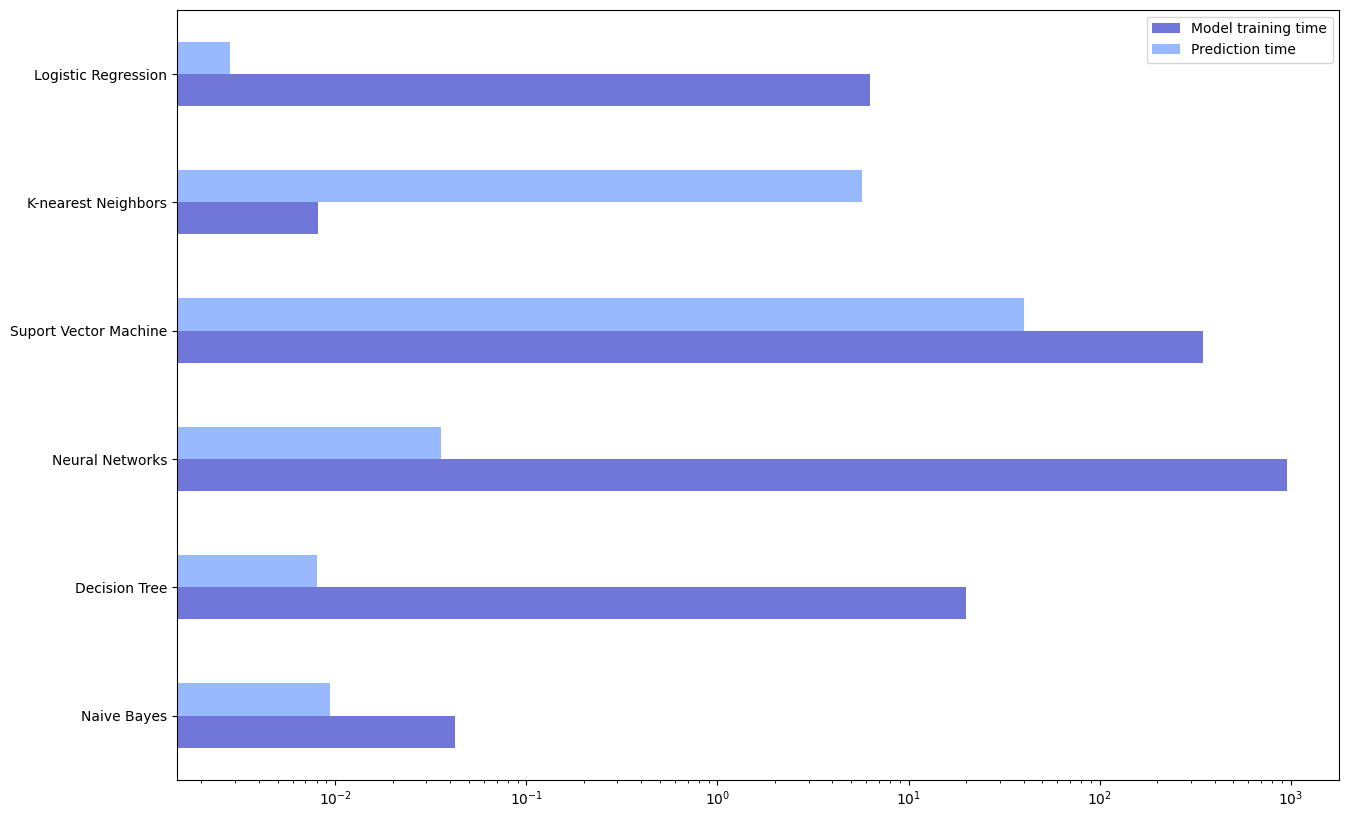

In [27]:
data = {
    'Model training time': times_fit,
    'Prediction time': times_predict,
}
df = pd.DataFrame(data, algorithms)
ax = df.plot.barh(color=['#7077D8', '#99B9FF'])
plt.xscale('log')

plt.show()
